In [36]:
from face_part_detection import FacePartDetection
from FaceRecognitionModel import FaceRecognitionModel
from face_quality import FaceQuality
import os

In [35]:
face_part = FacePartDetection()
face_reg = FaceRecognitionModel()
face_quality = FaceQuality()

[utils.onnxruntime] InferenceSession best_face_part.onnx ['CPUExecutionProvider']
[utils.onnxruntime] InferenceSession face_quality.onnx ['CPUExecutionProvider']


In [2]:
portraits = []
fronts = []
for label in os.listdir('images'):
    for file_name in os.listdir(f'images/{label}'):
        if 'front' in file_name:
            fronts.append(f'images/{label}/{file_name}')
        else:
            portraits.append(f'images/{label}/{file_name}')

In [27]:
org_pairs = []
org_labels = []
import random
from tqdm import tqdm

In [28]:
def check_pair(portrait,front):
    if portrait.replace('portrait','front') == front:
        return True
    return False

In [29]:
for portrait in portraits:
    for front in fronts:
        if check_pair(portrait,front):
            org_pairs.append((portrait,front))
            org_labels.append(1)
        else:            
            org_pairs.append((portrait,front))
            org_labels.append(0)

In [30]:
pairs = []
labels = []
count = 0
for label,pair in zip(org_labels,org_pairs):
    if label == 1:
        pairs.append(pair)
        labels.append(label)
    else:
        pairs.append(pair)
        labels.append(label)
        count+=1
    if count == 50000:
        break

In [31]:
def calculate_fnmr_fmr(predicted, ground_truth):
    total_genuine_matches = sum(ground_truth)
    total_impostor_pairs = len(ground_truth) - total_genuine_matches

    false_negatives = sum(1 for pred, truth in zip(predicted, ground_truth) if truth and not pred)
    false_positives = sum(1 for pred, truth in zip(predicted, ground_truth) if not truth and pred)

    fnmr = false_negatives / total_genuine_matches
    fmr = false_positives / total_impostor_pairs

    return fnmr, fmr

In [32]:
from sklearn.metrics import confusion_matrix
def calculate_far_frr(predicted, ground_truth):
    TN, FP, FN, TP = confusion_matrix(predicted,ground_truth).ravel()
    FAR = FP / (FP + TN)
    FRR = FN / (FN + TP)
    return FAR,FRR

In [33]:
from sklearn.metrics import accuracy_score
def calculate_acc(predicted, ground_truth):
    return accuracy_score(predicted,ground_truth)
    

In [37]:
from PIL import Image as PilImage
faces_part = []
quality_front_faces = []
quality_portrait_faces = []
scores = []
for front,portrait in tqdm(pairs):
    portrait_image = PilImage.open(portrait).convert("RGB")
    front_image = PilImage.open(front).convert("RGB")
    
    is_full_face,_,_,_ = face_part.detect(portrait_image)
    faces_part.append(is_full_face)
    
    score_portrait = face_quality.predict(portrait_image)
    quality_portrait_faces.append(score_portrait)
    
    score_front = face_quality.predict(front_image)
    quality_front_faces.append(score_front)
    
    score = face_reg.compare(portrait_image,front_image)
    scores.append(score)

  0%|          | 8/50015 [00:05<10:16:03,  1.35it/s]


KeyboardInterrupt: 

In [35]:
def calculate_precision(y_true, y_pred, label):
    # Count true positives (TP) and false positives (FP) for the specified label
    TP = sum((y_true == label) & (y_pred == label))
    FP = sum((y_true != label) & (y_pred == label))
    # Calculate precision
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    return precision

In [40]:
from sklearn.metrics import recall_score
def calculate_tpr(y_true,y_pred):
    return recall_score(y_true,y_pred)

In [9]:
y_org_pred = [1 if score >=0.8 else 0 for score  in scores]

In [43]:
import numpy as np
ratio_rejects = []
fnmrs = []
fmrs = []
fars = []
frrs = []
accs = []
precs_0 = []
precs_1 = []
tprs = []
thresholds = [i for i in range(0,45,1)]
for threshold in thresholds:
    y_true = []
    y_pred = []
    num_of_rejects = 0
    for face_part,quality_front,quality_portrait,cls,pred in zip(faces_part,quality_front_faces,quality_portrait_faces,labels,y_org_pred):
        if face_part:
            if quality_front>=threshold and quality_portrait>=threshold:
                y_true.append(cls)
                y_pred.append(pred)
            else:
                num_of_rejects+=1
        else:
            num_of_rejects+=1
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    acc = calculate_acc(y_pred,y_true)
    accs.append(acc)
    fnmr,fmr = calculate_fnmr_fmr(y_pred,y_true)
    far, frr = calculate_far_frr(y_pred,y_true)
    precs_0.append(calculate_precision(y_true,y_pred,0))
    precs_1.append(calculate_precision(y_true,y_pred,1))
    
    tpr = calculate_tpr(y_true,y_pred)
    tprs.append(tpr)
    
    reject = num_of_rejects/len(labels)
    ratio_rejects.append(reject)
    fars.append(far)
    frrs.append(frr)
    fnmrs.append(fnmr)
    fmrs.append(fmr)

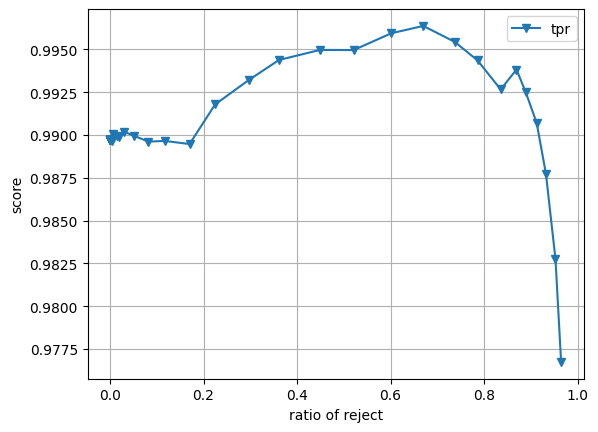

In [45]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ
plt.plot(ratio_rejects, tprs, label='tpr', marker='v')

# Đặt nhãn và tiêu đề
plt.xlabel('ratio of reject')
plt.ylabel('score')
plt.legend()

# Hiển thị biểu đồ
plt.grid(True)
plt.show()


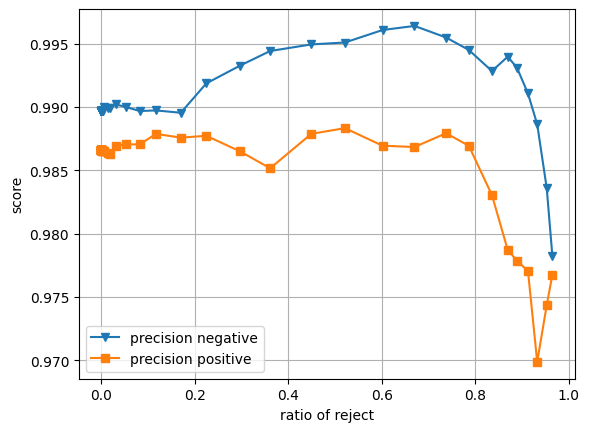

In [37]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ
plt.plot(ratio_rejects, precs_0, label='precision negative', marker='v')
plt.plot(ratio_rejects, precs_1, label='precision positive', marker='s')

# Đặt nhãn và tiêu đề
plt.xlabel('ratio of reject')
plt.ylabel('score')
plt.legend()

# Hiển thị biểu đồ
plt.grid(True)
plt.show()


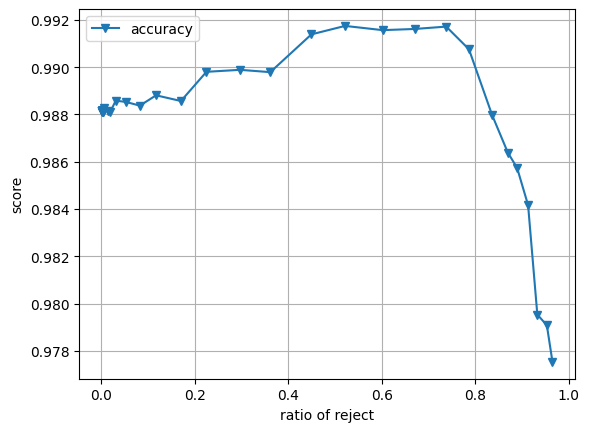

In [38]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ
plt.plot(ratio_rejects, accs, label='accuracy', marker='v')
# plt.plot(ratio_rejects, fnmrs, label='FNMR', marker='s')

# Đặt nhãn và tiêu đề
plt.xlabel('ratio of reject')
plt.ylabel('score')
plt.legend()

# Hiển thị biểu đồ
plt.grid(True)
plt.show()


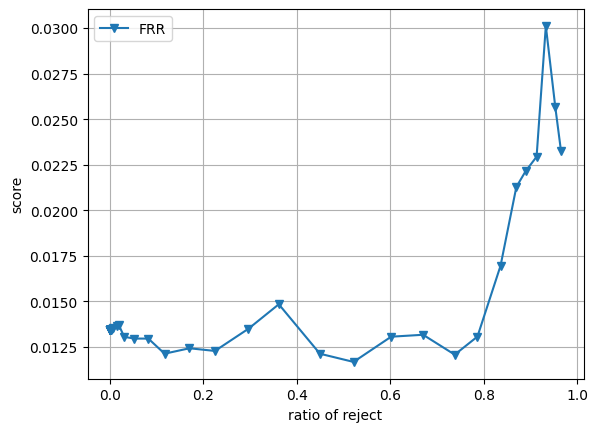

In [39]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ
plt.plot(ratio_rejects, frrs, label='FRR', marker='v')
# plt.plot(ratio_rejects, fnmrs, label='FAR', marker='s')

# Đặt nhãn và tiêu đề
plt.xlabel('ratio of reject')
plt.ylabel('score')
plt.legend()

# Hiển thị biểu đồ
plt.grid(True)
plt.show()
